### Détection d'Anomalies en Cybersécurité avec le Jeu de Données KDD99

Ce guide décrit les étapes pour détecter des anomalies dans le jeu de données KDD99, une référence pour la détection d'intrusions en cybersécurité. L'objectif est d'identifier les anomalies (intrusions) dans les données de trafic réseau.

---

### **1. Préparation des Données**

#### **1.1 Obtenir le Jeu de Données**
Le jeu de données KDD99 peut être obtenu à partir de sa source originale ou via la bibliothèque `scikit-learn`. Ici, nous utilisons la fonction `fetch_kddcup99` de `scikit-learn` pour charger les données.

In [49]:
from sklearn.datasets import fetch_kddcup99
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
# Charger le jeu de données KDD99
data = fetch_kddcup99(subset='http', percent10=True, return_X_y=False)
X = data.data
y = data.target

#### **1.2 Explorer le Jeu de Données**
Explorons le jeu de données pour comprendre sa structure et ses attributs.

In [51]:
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

# Afficher les informations de base
print(df.info())
print("=============================================")

print(df.head())
print("=============================================")


# Distribution des étiquettes
print(df['target'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58725 entries, 0 to 58724
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   duration   58725 non-null  object
 1   src_bytes  58725 non-null  object
 2   dst_bytes  58725 non-null  object
 3   target     58725 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB
None
   duration src_bytes dst_bytes      target
0 -2.302585  5.199049  8.603389  b'normal.'
1 -2.302585  5.476882  6.186414  b'normal.'
2 -2.302585  5.460011  7.198258  b'normal.'
3 -2.302585  5.389528  7.198258  b'normal.'
4 -2.302585  5.380358  7.616825  b'normal.'
target
b'normal.'     56516
b'back.'        2203
b'phf.'            4
b'ipsweep.'        1
b'satan.'          1
Name: count, dtype: int64


#### **1.3 Comprendre les Attributs**
Le jeu de données KDD99 contient 41 caractéristiques, notamment :
- **Caractéristiques de base** : Durée, type de protocole, service, flag, etc.
- **Caractéristiques de contenu** : Nombre de tentatives de connexion échouées, etc.
- **Caractéristiques de trafic** : Nombre de connexions au même hôte, etc.

La variable cible (`y`) indique si une connexion est normale ou une attaque (anomalie).

#### **1.4 Visualiser les Données**

In [52]:
print(df[['duration', 'target']].head())

   duration      target
0 -2.302585  b'normal.'
1 -2.302585  b'normal.'
2 -2.302585  b'normal.'
3 -2.302585  b'normal.'
4 -2.302585  b'normal.'


/var/folders/m2/d1mw5wj10rdfwjr3_bnnrxwr0000gn/T/ipykernel_41787/337349453.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='target', y='duration', palette='muted')


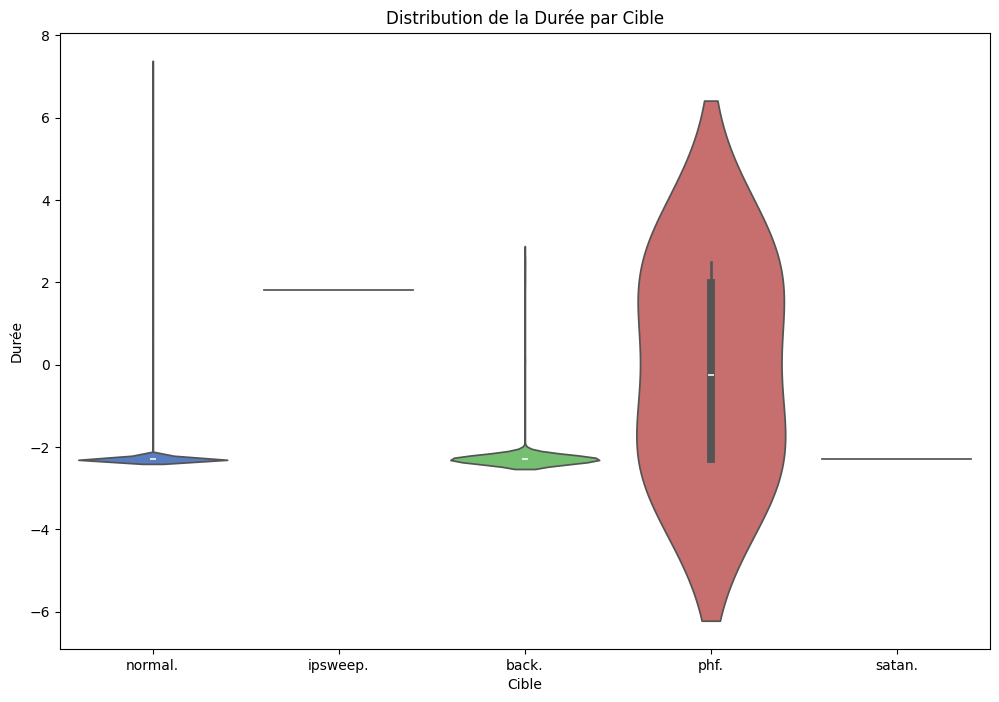

In [53]:
# Convertir les colonnes numériques en float
df['duration'] = pd.to_numeric(df['duration'], errors='coerce')
df['src_bytes'] = pd.to_numeric(df['src_bytes'], errors='coerce')
df['dst_bytes'] = pd.to_numeric(df['dst_bytes'], errors='coerce')

# Graphique en violon
plt.figure(figsize=(12, 8))
sns.violinplot(data=df, x='target', y='duration', palette='muted')

plt.title('Distribution de la Durée par Cible')
plt.xlabel('Cible')
plt.ylabel('Durée')
plt.show()

### **2. Entraînement du Modèle**

#### **2.1 Prétraiter les Données**

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Identifier les colonnes numériques
numerical_cols = ['duration', 'src_bytes', 'dst_bytes']

# Pipeline de prétraitement
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols)
    ])

# Appliquer le prétraitement
X_processed = preprocessor.fit_transform(df.drop('target', axis=1))

print("Prétraitement terminé.")


Prétraitement terminé.


#### **2.2 Diviser les Données**
Diviser les données en ensembles d'entraînement et de test.

In [55]:
from sklearn.model_selection import train_test_split

# Convertir les étiquettes en binaire : 1 pour anomalie, 0 pour normal
y_binary = (y != b'normal.').astype(int)

# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_binary, test_size=0.05, random_state=42)

#### **2.3 Entraîner un Modèle de Détection d'Anomalies**
Nous utiliserons l'algorithme **Isolation Forest**, efficace pour la détection d'anomalies.

In [56]:
from sklearn.ensemble import IsolationForest

# Entraîner le modèle
model = IsolationForest(contamination=0.1, random_state=42)  # contamination est la proportion attendue d'anomalies
model.fit(X_train)

IsolationForest(contamination=0.1, random_state=42)

### **3. Évaluation des Performances du Modèle**

#### **3.1 Prédire les Anomalies**
Utiliser le modèle entraîné pour prédire les anomalies sur l'ensemble de test.

In [57]:
# Prédire les anomalies (1 pour normal, -1 pour anomalie)
y_pred = model.predict(X_test)

# Convertir les prédictions en binaire (0 pour normal, 1 pour anomalie)
y_pred_binary = (y_pred == -1).astype(int)

#### **3.2 Évaluer les Performances**
Calculer la **Précision** et le **Rappel** pour évaluer les performances du modèle.

In [58]:
from sklearn.metrics import precision_score, recall_score

# Calculer la précision et le rappel
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)

print(f'Précision: {precision:.4f}')
print(f'Rappel: {recall:.4f}')

Précision: 0.3977
Rappel: 1.0000


#### **3.3 Matrice de Confusion**
Visualiser les résultats à l'aide d'une matrice de confusion.

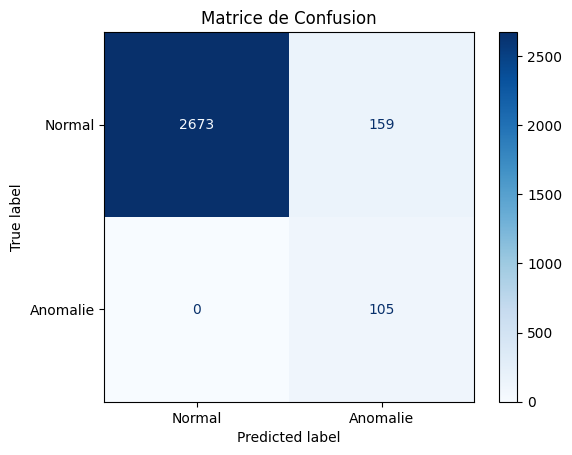

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_binary)

# Tracer la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomalie'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion')
plt.show()